## Task 4: Multiple Regression Model

**Description:**  
In this task, we will build a **multiple regression model** to predict sales using all the engineered features from our dataset. Unlike a simple regression that uses a single predictor, multiple regression considers multiple independent variables simultaneously, allowing us to capture more complex relationships in the data.

**Features to Use:**  
- **Promotions:** Whether items were on promotion during the period.  
- **Holidays:** Flags for public holidays or special events affecting sales.  
- **Store Type:** Different store categories which may influence sales patterns.  
- **Other Engineered Features:** Such as day, month, weekday, and lag features.  

**Steps to Perform:**  
1. **Data Preparation:** Select relevant features and split data into training and testing sets.  
2. **Model Training:** Fit a multiple linear regression model using the training data.  
3. **Evaluation:** Assess model performance using metrics such as:
   - **RMSE (Root Mean Squared Error):** Measures the average magnitude of prediction errors.  
   - **MAE (Mean Absolute Error):** Measures the average absolute difference between predicted and actual values.  

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import joblib   
plt.style.use('seaborn')  

In [3]:
df = pd.read_csv(r"C:\Users\Deepti\Downloads\train.csv",parse_dates=["date"])
print("Raw shape:", df.shape)
df.head()

Raw shape: (3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
df.info()
print("\nColumns:", df.columns.tolist())
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nBasic descriptive stats for numeric columns:")
display(df.describe().T)

print("\nUnique store_nbr count:", df['store_nbr'].nunique())
print("Unique family count:", df['family'].nunique())
print("Example families:", df['family'].unique()[:10])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB

Columns: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion']

Missing values per column:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Basic descriptive stats for numeric columns:


,count,mean,min,25%,50%,75%,max,std
id,3000888.0,1500443.5,0.0,750221.75,1500443.5,2250665.25,3000887.0,866281.891642
date,3000888,2015-04-24 08:27:04.703088384,2013-01-01 00:00:00,2014-02-26 18:00:00,2015-04-24 12:00:00,2016-06-19 06:00:00,2017-08-15 00:00:00,NaN
store_nbr,3000888.0,27.5,1.0,14.0,27.5,41.0,54.0,15.585787
sales,3000888.0,357.775749,0.0,0.0,11.0,195.84725,124717.0,1101.997721
onpromotion,3000888.0,2.60277,0.0,0.0,0.0,0.0,741.0,12.218882



Unique store_nbr count: 54
Unique family count: 33
Example families: ['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI']


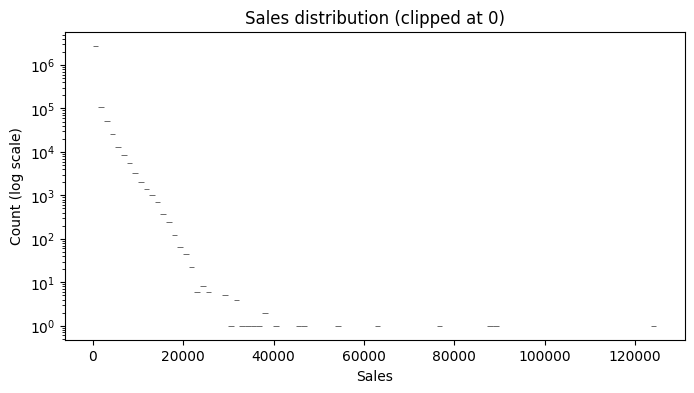

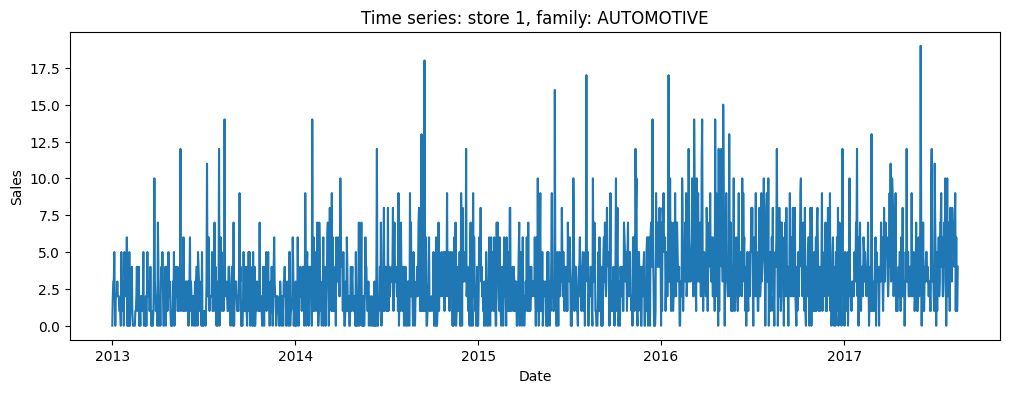

In [6]:
plt.figure(figsize=(8,4))
sns.histplot(df['sales'].clip(lower=0), bins=100, log_scale=(False, True))  # log-scale on y to handle skew
plt.title("Sales distribution (clipped at 0)")
plt.xlabel("Sales")
plt.ylabel("Count (log scale)")
plt.show()

# Time series snapshot for one store & family 
example_store = df['store_nbr'].iloc[0]
example_family = df['family'].iloc[0]
sample_ts = df[(df['store_nbr']==example_store) & (df['family']==example_family)].sort_values('date')
if not sample_ts.empty:
    plt.figure(figsize=(12,4))
    plt.plot(sample_ts['date'], sample_ts['sales'])
    plt.title(f"Time series: store {example_store}, family: {example_family}")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.show()
else:
    print("No sample time series for the chosen example.")

In [7]:
data = df.copy()
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['weekday'] = data['date'].dt.weekday  # Monday=0 ... Sunday=6
data['is_weekend'] = data['weekday'].isin([5,6]).astype(int)  

if 'onpromotion' in data.columns:
    data['onpromotion'] = data['onpromotion'].fillna(0).astype(int)

data['days_from_start'] = (data['date'] - data['date'].min()).dt.days
display(data[['date','year','month','day','weekday','is_weekend','onpromotion','days_from_start']].head())


,date,year,month,day,weekday,is_weekend,onpromotion,days_from_start
0,2013-01-01,2013,1,1,1,0,0,0
1,2013-01-01,2013,1,1,1,0,0,0
2,2013-01-01,2013,1,1,1,0,0,0
3,2013-01-01,2013,1,1,1,0,0,0
4,2013-01-01,2013,1,1,1,0,0,0


In [8]:
TARGET = "sales"

numeric_features = ['year','month','day','weekday','is_weekend','onpromotion','days_from_start']
categorical_features = ['store_nbr','family']

print("Missing target values:", data[TARGET].isnull().sum())

X = data[numeric_features + categorical_features].copy()
y = data[TARGET].copy()

print("X shape:", X.shape, "y shape:", y.shape)
X.head()

Missing target values: 0
X shape: (3000888, 9) y shape: (3000888,)


,year,month,day,weekday,is_weekend,onpromotion,days_from_start,store_nbr,family
0,2013,1,1,1,0,0,0,1,AUTOMOTIVE
1,2013,1,1,1,0,0,0,1,BABY CARE
2,2013,1,1,1,0,0,0,1,BEAUTY
3,2013,1,1,1,0,0,0,1,BEVERAGES
4,2013,1,1,1,0,0,0,1,BOOKS


In [11]:
X_star = X.copy()
X_star = pd.get_dummies(X_star, columns=['store_nbr', 'family'], drop_first=True)

print("Shape after encoding: ", X_star.shape)
X_star.head()

Shape after encoding:  (3000888, 92)


,year,month,day,weekday,is_weekend,onpromotion,days_from_start,store_nbr_2,store_nbr_3,store_nbr_4,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
0,2013,1,1,1,0,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2013,1,1,1,0,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2013,1,1,1,0,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2013,1,1,1,0,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2013,1,1,1,0,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [13]:
X_train_star, X_test_star, y_train_star, y_test_star = train_test_split(X_star, y, test_size=0.2, random_state=42)

print("Train shape:", X_train_star.shape, "Test shape:", X_test_star.shape)

Train shape: (2400710, 92) Test shape: (600178, 92)


In [15]:
model_star = LinearRegression()
model_star.fit(X_train_star, y_train_star)

print("Model trained successfully!")

Model trained successfully!


In [17]:
y_pred_star = model_star.predict(X_test_star)

mse_star = mean_squared_error(y_test_star, y_pred_star)
rmse_star = mse_star ** 0.5   

mae_star = mean_absolute_error(y_test_star, y_pred_star)
r2_star = r2_score(y_test_star, y_pred_star)

print(f"RMSE: {rmse_star:.2f}")
print(f"MAE : {mae_star:.2f}")
print(f"R2 Score: {r2_star:.2f}")

RMSE: 722.01
MAE : 303.35
R2 Score: 0.58


In [25]:
print("Intercept (Bias):", model_star.intercept_)
coefficients = pd.DataFrame({'Feature': X_train_star.columns,'Coefficient': model_star.coef_})

coefficients

Intercept (Bias): -5704921.761672498


,Feature,Coefficient
0,year,2833.817938
1,month,239.903414
2,day,6.153511
3,weekday,-11.905394
4,is_weekend,181.444310
...,...,...
87,family_POULTRY,301.607264
88,family_PREPARED FOODS,84.432822
89,family_PRODUCE,1126.315293
90,family_SCHOOL AND OFFICE SUPPLIES,-5.157705


In [26]:
# Sort coefficients
coeff_sorted = coefficients.sort_values(by='Coefficient')

print("🔻 Features that DECREASE sales prediction:")
display(coeff_sorted.head(10))

print("🔺 Features that INCREASE sales prediction:")
display(coeff_sorted.tail(10))


🔻 Features that DECREASE sales prediction:


,Feature,Coefficient
57,store_nbr_52,-175.605527
27,store_nbr_22,-171.060427
37,store_nbr_32,-134.091144
35,store_nbr_30,-112.249651
40,store_nbr_35,-109.328056
31,store_nbr_26,-109.177213
26,store_nbr_21,-94.662049
47,store_nbr_42,-91.155720
34,store_nbr_29,-87.052130
58,store_nbr_53,-74.575150


🔺 Features that INCREASE sales prediction:


,Feature,Coefficient
67,family_DAIRY,563.923073
52,store_nbr_47,639.887963
8,store_nbr_3,641.915149
50,store_nbr_45,703.605541
49,store_nbr_44,837.983205
66,family_CLEANING,941.690851
89,family_PRODUCE,1126.315293
62,family_BEVERAGES,2209.535977
0,year,2833.817938
71,family_GROCERY I,3393.117856


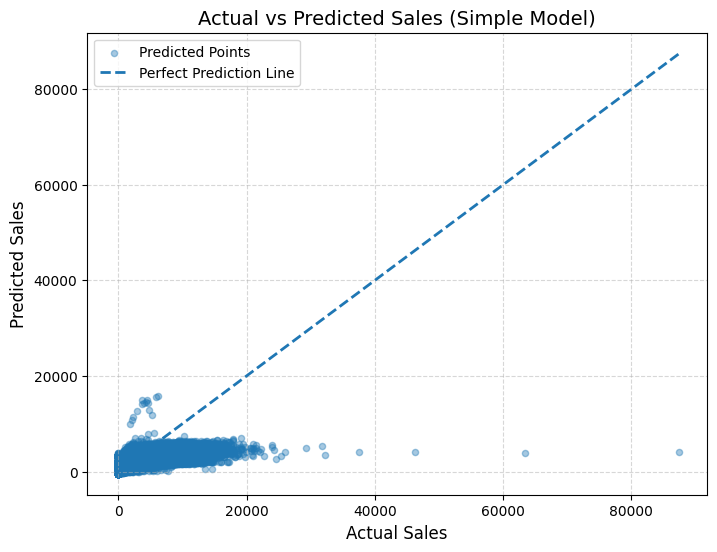

In [27]:
plt.figure(figsize=(8,6))
plt.scatter(y_test_star, y_pred_star, alpha=0.4, s=20, label="Predicted Points")
min_val = min(y_test_star.min(), y_pred_star.min())
max_val = max(y_test_star.max(), y_pred_star.max())

plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', linewidth=2, label="Perfect Prediction Line")

plt.xlabel("Actual Sales", fontsize=12)
plt.ylabel("Predicted Sales", fontsize=12)
plt.title("Actual vs Predicted Sales (Simple Model)", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()